<a href="https://colab.research.google.com/github/sohamthirty/Stock-Price-Prediction-with-Sentiment-Analysis/blob/main/Financial_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#!pip install requests
# !pip install bs4
#!pip install python-decouple
#!pip install langdetect

In [1]:
import pandas as pd
import requests as req
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

In [8]:
df_analytics = pd.read_csv("analyst_ratings_processed.csv", encoding='UTF-8')
df_analytics['stock'] = df_analytics['stock'].replace(['GOOG', 'GOOGL'], 'GOOGL')
df_analyst_rating = pd.read_csv("raw_analyst_ratings.csv", encoding = 'UTF-8')
df_partner_headlines= pd.read_csv("raw_partner_headlines.csv", encoding = 'UTF-8')

In [9]:
## Entire dataset
num_rows_df_analytics = len(df_analytics)
print("Number of rows in the df_analytics:", num_rows_df_analytics)

num_rows_df_analyst_rating = len(df_analyst_rating)
print("Number of rows in the df_analyst_rating:", num_rows_df_analyst_rating)

num_rows_df_partner_headlines = len(df_partner_headlines)
print("Number of rows in the df_partner_headlines:", num_rows_df_partner_headlines)

Number of rows in the df_analytics: 1400469
Number of rows in the df_analyst_rating: 1407328
Number of rows in the df_partner_headlines: 1845559


In [10]:
def filter_dataframe (df):
  startdate = pd.to_datetime("2015-01-01").date()
  enddate = pd.to_datetime("2020-12-31").date()
  df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
  df['date'] = df['date'].dt.date
  df = df.loc[(df['date'] >= startdate) & (df['date'] <= enddate)]
  return df

In [11]:
df_analytics = filter_dataframe(df_analytics)
df_analyst_rating = filter_dataframe(df_analyst_rating)
df_partner_headlines = filter_dataframe(df_partner_headlines)

In [12]:
def get_statistics(df):
  num_rows = len(df)
  print("Total Number of rows in the df_analyst_rating from 2015-2020:", num_rows)
  categories_to_check = ['AAPL', 'GOOG','GOOGL', 'AMZN', 'MSFT','TSLA']
  filtered_df = df[df['stock'].isin(categories_to_check)]
  print("unique tickers : ", filtered_df['stock'].unique())
  print(filtered_df["stock"].value_counts())
  filtered_df['year'] = pd.DatetimeIndex(filtered_df['date']).year
  yearly_counts = filtered_df.groupby('year').size()
  print("\n")
  print("Yearly Counts")
  print(yearly_counts)
  return filtered_df

In [13]:
filtered_analytics  = get_statistics(df_analytics)

filtered_analytics.tail()

Total Number of rows in the df_analyst_rating from 2015-2020: 796658
unique tickers :  ['AAPL' 'AMZN' 'GOOGL' 'TSLA']
stock
GOOGL    2794
TSLA     1930
AAPL      469
AMZN      330
Name: count, dtype: int64


Yearly Counts
year
2018     343
2019    2210
2020    2970
dtype: int64


,Unnamed: 0,title,date,stock,year
1250207,1263065.0,Electrek.Co Tweet: Tesla's head of Europe is out,2019-07-02,TSLA,2019
1250208,1263066.0,Tesla's Q2 Delivery Number Could Cause A Big Move,2019-07-01,TSLA,2019
1250209,1263067.0,'Tesla Electric Airplane? Elon Musk sees elect...,2019-07-01,TSLA,2019
1250210,1263068.0,"UPDATE: JMP Reiterates Outperform, $347 Target...",2019-07-01,TSLA,2019
1250211,1263069.0,Tesla shares are trading higher after JMP Secu...,2019-07-01,TSLA,2019


In [14]:
filtered_ratings = get_statistics(df_analyst_rating)
filtered_ratings.head()

Total Number of rows in the df_analyst_rating from 2015-2020: 51611
unique tickers :  ['AAPL' 'AMZN' 'GOOG' 'GOOGL' 'TSLA']
stock
AAPL     10
AMZN     10
GOOG     10
GOOGL    10
TSLA     10
Name: count, dtype: int64


Yearly Counts
year
2020    50
dtype: int64


,Unnamed: 0,headline,url,publisher,date,stock,year
6680,7120,Tech Stocks And FAANGS Strong Again To Start D...,https://www.benzinga.com/government/20/06/1622...,JJ Kinahan,2020-06-10,AAPL,2020
6681,7121,10 Biggest Price Target Changes For Wednesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-06-10,AAPL,2020
6682,7122,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",https://www.benzinga.com/short-sellers/20/06/1...,Benzinga Newsdesk,2020-06-10,AAPL,2020
6683,7123,"Deutsche Bank Maintains Buy on Apple, Raises P...",https://www.benzinga.com/news/20/06/16219873/d...,Benzinga Newsdesk,2020-06-10,AAPL,2020
6684,7124,Apple To Let Users Trade In Their Mac Computer...,https://www.benzinga.com/news/20/06/16218697/a...,Neer Varshney,2020-06-10,AAPL,2020


In [15]:
filtered_headlines  = get_statistics(df_partner_headlines)
filtered_headlines.head()

Total Number of rows in the df_analyst_rating from 2015-2020: 1473940
unique tickers :  ['AAPL' 'GOOG' 'GOOGL']
stock
GOOGL    175
AAPL      32
GOOG       5
Name: count, dtype: int64


Yearly Counts
year
2020    212
dtype: int64


,Unnamed: 0,headline,url,publisher,date,stock,year
4067,4130,American Pie,https://talkmarkets.com/content/american-pie?p...,TalkMarkets,2020-06-02,AAPL,2020
4068,4131,Tech Giants Dare Antitrust Deal Watchdogs,https://talkmarkets.com/content/tech-giants-da...,TalkMarkets,2020-06-02,AAPL,2020
4069,4132,MoneyGram Shares Jump 50% As Western Union Rep...,https://talkmarkets.com/content/moneygram-shar...,TalkMarkets,2020-06-02,AAPL,2020
4070,4133,All Eyes on Market Volatility,https://talkmarkets.com/content/all-eyes-on-ma...,TalkMarkets,2020-06-01,AAPL,2020
4071,4134,Warren Buffett's Berkshire Hathaway Turns Up S...,http://www.gurufocus.com/news/1152965/warren-b...,GuruFocus,2020-06-01,AAPL,2020


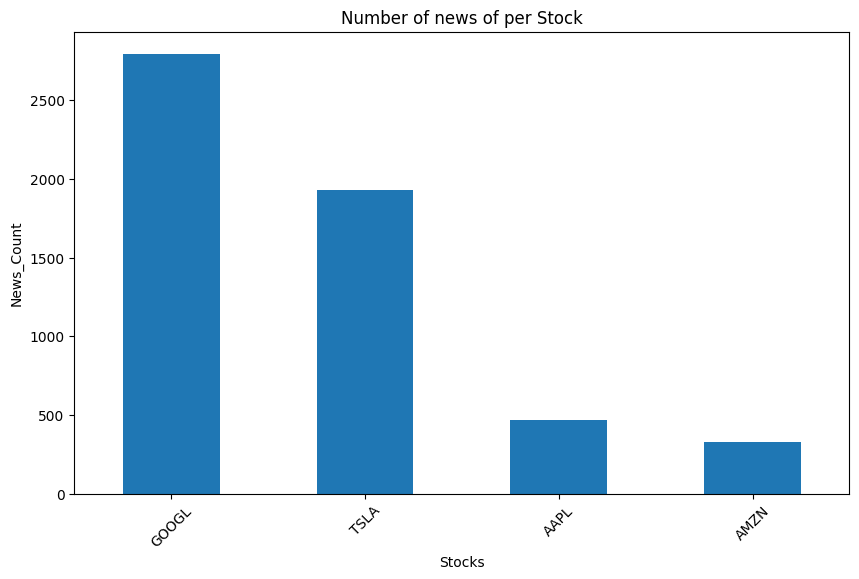

In [16]:
# Plot a bar chart
stock_counts = filtered_analytics["stock"].value_counts()
plt.figure(figsize=(10, 6))
stock_counts.plot(kind='bar')
plt.xlabel('Stocks')
plt.ylabel('News_Count')
plt.title('Number of news of per Stock')
plt.xticks(rotation=45)
plt.show()

In [17]:
df_analytics['year'] = pd.DatetimeIndex(df_analytics['date']).year
yearly_counts = df_analytics.groupby('year').size()
yearly_counts

year
2015    132877
2016    141314
2017    120299
2018    146413
2019    150080
2020    105675
dtype: int64

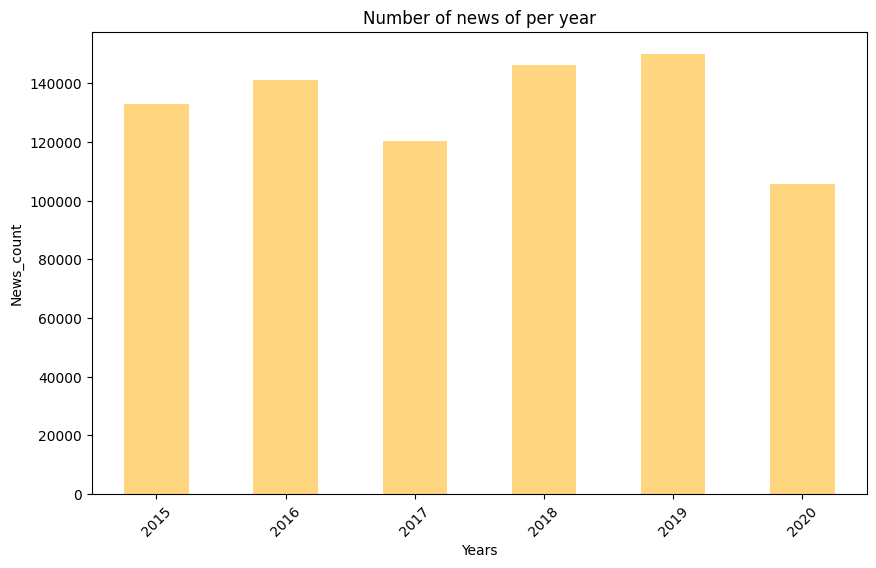

In [18]:
df_analytics['year'] = pd.DatetimeIndex(df_analytics['date']).year
yearly_counts = df_analytics.groupby('year').size()
plt.figure(figsize=(10, 6))
yearly_counts.plot(kind='bar',color='#FFD580')
plt.xlabel('Years')
plt.ylabel('News_count')
plt.title('Number of news of per year')
plt.xticks(rotation=45)
plt.show()

**Table of contents**<a id='toc0_'></a>    
- [Reuters data](#toc1_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

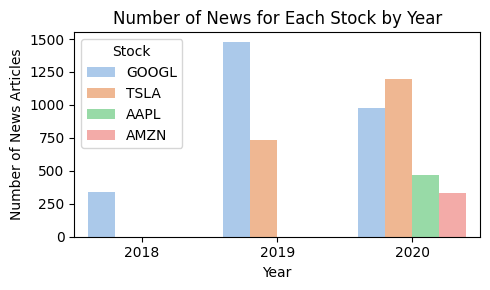

In [22]:
yearly_stock_counts = filtered_analytics.groupby(['year', 'stock']).size().reset_index(name='count')
colors = sns.color_palette("pastel")
plt.figure(figsize=(5, 3))
sns.barplot(data=yearly_stock_counts, x='year', y='count', hue='stock', palette=colors)
plt.xlabel('Year')
plt.ylabel('Number of News Articles')
plt.title('Number of News for Each Stock by Year')
plt.legend(title='Stock', loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()

In [20]:
def plot_wordcloud(ticker_name):

  category = ticker_name

  # Filter DataFrame for the specific category
  filtered_cat = filtered_analytics[filtered_analytics['stock'] == category]
  text = ' '.join(filtered_cat['title'])

  # Generate the word cloud
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

  # Plot the word cloud
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for "{category}" Stock')
  plt.show()

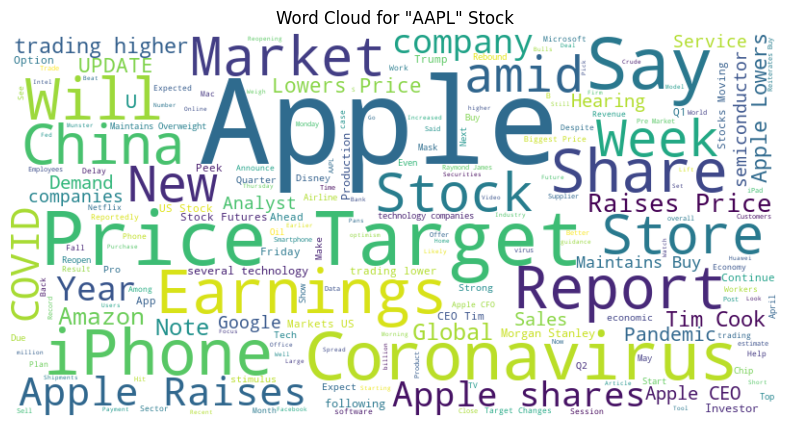

In [21]:
plot_wordcloud("AAPL")

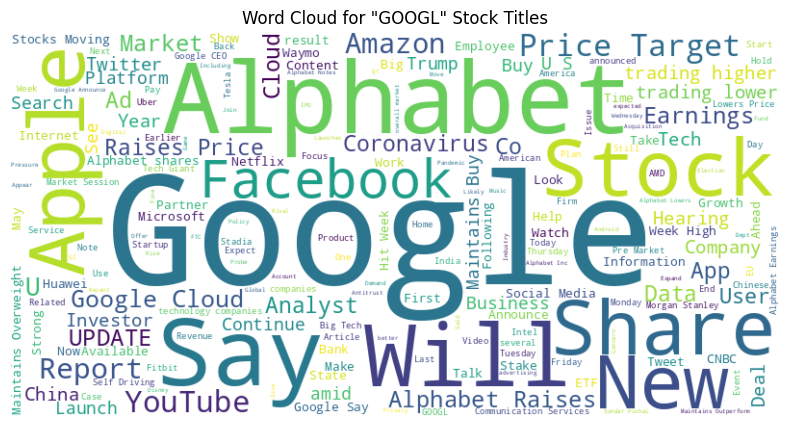

In [24]:
plot_wordcloud("GOOGL")

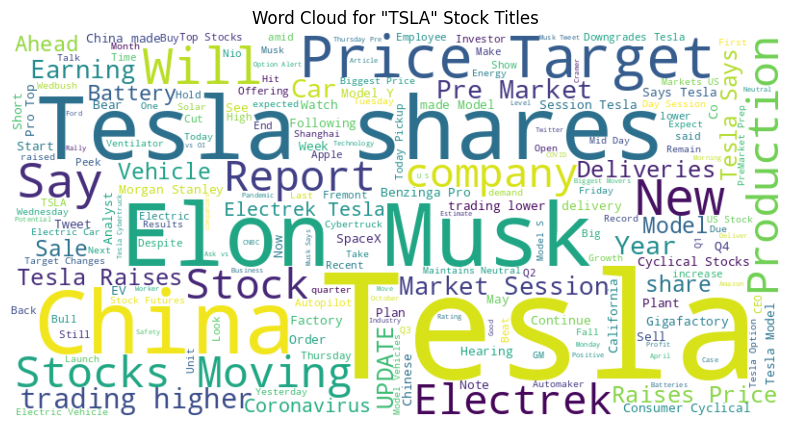

In [25]:
plot_wordcloud("TSLA")

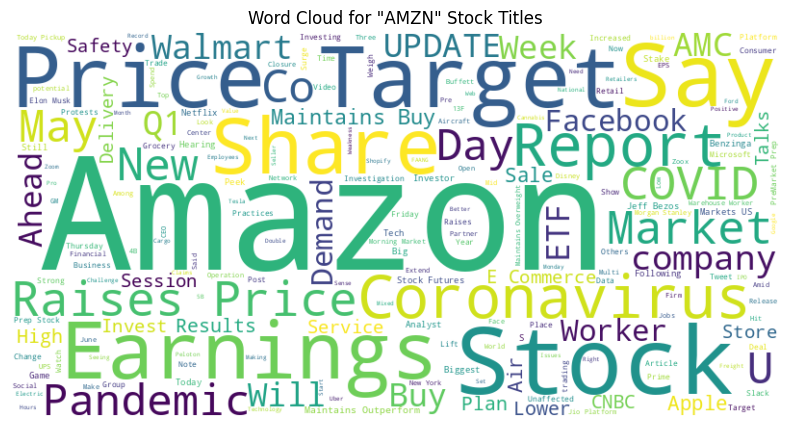

In [26]:
plot_wordcloud("AMZN")

### <a id='toc1_1_1_'></a>[Reuters data](#toc0_)

In [ ]:
import pandas as pd
df_24_hrs = pd.read_json('Reuters_20170607_to_20170719_24hrs.json', lines=True)

In [ ]:
df_24_hrs.head()

In [ ]:
df_24_hrs['news_time'] = pd.to_datetime(df_24_hrs['news_time'], errors='coerce', utc=True)

In [ ]:
df_24_hrs['news_time'] = df_24_hrs['news_time'].dt.date

In [ ]:
# Filter the DataFrame based on the startdate and enddate
startdate = pd.to_datetime("2015-01-01").date()
enddate = pd.to_datetime("2020-12-31").date()

df_24_hrs = df_24_hrs.loc[(df_24_hrs['news_time'] >= startdate) & (df_24_hrs['news_time'] <= enddate)]

In [ ]:
df_10to4 = pd.read_json('Reuters_20170607_to_20170721_10amTo4pm.json', lines=True)

In [ ]:
df_10to4.tail()

In [ ]:
api_url = "https://api.news-api.site/api/v1/news/articles-by-date/{date}"
response = req.get(api_url)

In [ ]:
response.json()

In [ ]:
!git clone https://github.com/MJ-API-Development/cloudflare-worker-financial-news-api.git

In [ ]:
b

In [ ]:
# Define the API endpoint URL and your API key
endpoint_url = "https://api.news-api.site/api/v1/news/articles-by-date/"
api_key = "71ad5fdaeb5954b4b0913f84b0b8056136417"  # Replace with your actual API key


date = '20215-03-02'

# Construct the full URL with the provided date
url = f"{endpoint_url}{date}"

# Set up the query parameters including the API key
query_params = {
    "api_key": api_key
}

# Send a GET request to the API endpoint
response = req.get(url, params=query_params)

# Check if the request was successful (HTTP status code 200)
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    # Now, 'data' contains the response from the API, which you can work with in your Python code
    print(data)
else:
    # If the request was not successful, print an error message
    print("Error: Unable to fetch data. Status code", response.status_code)